In [1]:
# import libraries
import numpy as np
from scipy.special import hermite
import math
from math import factorial
from scipy.constants import hbar
from scipy.stats import skew
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from astropy import stats
import random
import yfinance as yf
from yahoofinancials import YahooFinancials
from statsmodels.distributions.empirical_distribution import ECDF
from hurst import compute_Hc, random_walk

%matplotlib inline
sns.set()

## Importing Files from Yahoo Finance

In [2]:
# import BTC-EUR prices for the three holding periods in dataframe format
BTC_daily_df = yf.download('BTC-EUR',start='1996-09-21',end='2021-09-01',interval='1d',progress=False)
BTC_weekly_df = yf.download('BTC-EUR',start='1996-09-21',end='2021-09-01',interval='1wk',progress=False)
BTC_monthly_df = yf.download('BTC-EUR',start='1996-09-21',end='2021-09-01',interval='1mo',progress=False)

In [3]:
#BTC-EUR prices in np.array
BTC_daily = np.array(BTC_daily_df)[:,4]
BTC_weekly = np.array(BTC_weekly_df)[:,4]
BTC_monthly = np.array(BTC_monthly_df)[:,4]
BTC = np.array([BTC_daily,BTC_weekly,BTC_monthly])

<ipython-input-3-7392e6411401>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  BTC = np.array([BTC_daily,BTC_weekly,BTC_monthly])


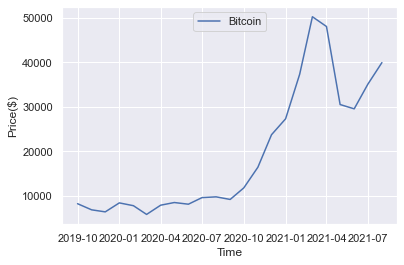

In [86]:
plt.plot(BTC_monthly_df.Close, label='Bitcoin')
plt.xlabel('Time')
plt.ylabel('Price($)')
plt.legend(loc="upper center")

In [4]:
#returns of a stock price
def stockreturns(x):
    return([x[i+1]/x[i] for i in range(len(x)-1)])
#log-returns of a stock price
def logreturns(x):
    return([np.log(x[i+1]/x[i]) for i in range(len(x)-1)])

In [5]:
#compounded returns of a stock price
def compounded_returns(x,t):
    if t==0: #daily
        return (252.5/1*np.array(logreturns(x[t])))
    if t==1: #weekly
        return (252.5/5*np.array(logreturns(x[t])))
    if t==2: #monthly
        return (252.5/20*np.array(logreturns(x[t])))
    else:
        return

In [6]:
#moment, skewness and kurtosis of a dataset
def moment(g,x):
    return np.sum([(b-np.mean(x))**g for b in x])/len(x)
def skeww(x):
    return moment(3,x)/(moment(2,x)**(3/2))
def kurto(x):
    return (moment(4,x)/moment(2,x)**2)-3

### Summary statistics of stock returns for different holding periods

### BTC-EUR

In [9]:
crBTC1 = compounded_returns(BTC,0)
crBTC5 = compounded_returns(BTC,1)
crBTC20 = compounded_returns(BTC,2)

#hurst numbers for daily, weekly and monthly compounded returns
H_1=compute_Hc(crBTC1)[0]
H_5=compute_Hc(crBTC5)[0]
#H_20=compute_Hc(crBTC20)[0]

dfBTC = pd.DataFrame(np.array([['1', len(crBTC1),round(np.mean(crBTC1),6),round(np.std(crBTC1),6),round(skeww(crBTC1),6),round(kurto(crBTC1),6),round(ApEn(crBTC1, m=2, r=3),6),round(H_1,6)], ['5', len(crBTC5),round(np.mean(crBTC5),6),round(np.std(crBTC5),6),round(skeww(crBTC5),6),round(kurto(crBTC5),6),round(ApEn(crBTC5, m=2, r=3),6),round(H_5,6)], ['20', len(crBTC20),round(np.mean(crBTC20),6),round(np.std(crBTC20),6),round(skeww(crBTC20),6),round(kurto(crBTC20),6),round(ApEn(crBTC20, m=2, r=3),6),'\\']]),
                   columns=['τ', 'N° of observations', 'Mean','Std','Skewness','Excess kurtosis','Entropy','Hurst'])
dfBTC

,τ,N° of observations,Mean,Std,Skewness,Excess kurtosis,Entropy,Hurst
0,1,709,0.521054,10.278073,-1.796037,24.163128,1.382873,0.378651
1,5,102,0.730159,5.245185,-0.918976,1.974489,0.911239,0.26425
2,20,22,0.905355,2.676114,-0.592423,-0.230043,0.515338,\


### Theoretical probability function

In [10]:
N = 5 #numero di oscillatori armonici considerati

In [11]:
#Quantum PDF
def psisquare(C,y):
    N = len(C)-1
    P = np.zeros((N,len(y)))
    y = np.sort(y)
    for i in range(N):
        P[i,:]=C[i]*np.exp(-C[-1]*y**2)*hermite(i)(np.sqrt(C[-1])*y)
        
    return P.sum(axis=0)/np.trapz(P.sum(axis=0),y)    

## FITNESS FUNCTION 

### Entropy of a vector

In [12]:
#entropy of a vector
def ApEn(U, m, r):
    U = np.array(U)
    N = U.shape[0]
            
    def _phi(m):
        z = N - m + 1.0
        x = np.array([U[i:i+m] for i in range(int(z))])
        X = np.repeat(x[:, np.newaxis], 1, axis=2)
        C = np.sum(np.absolute(x - X).max(axis=2) <= r, axis=0) / z
        return np.log(C).sum() / z
    
    return abs(_phi(m + 1) - _phi(m))

### ECDF of a distribution

In [13]:
# Creating our ecdf function
def ecdf(data):
    """ 
    This function creates the x and y axis for a ecdf
    plot given the data as input.
    """
    xaxis = np.sort(data)
    yaxis = np.arange(1,len(data)+1)/len(data)
    return xaxis, yaxis

## Genetic Algorithm to optimize description of financial indices

### GA Functions

\begin{equation}
KL(\tilde{p}||q (θ|.)) = - \frac{1}{M} \sum_{μ=1}^{M} log(x^μ|θ) - S(\tilde{p})
\end{equation}

In [14]:
#Quantum Fitness function of a vector
def Fitness(x,C):
    
    M = len(x)
    
    return -(M)**(-1)*sum(np.log(psisquare(C,x)))# - ApEn(ecdf(x)[1], m=2, r=3)

#funzione fitness, si occupa di dare un punteggio ad ogni vettore C, vince quello con il punteggio minore

In [15]:
#quantum fitness function of a matrix
def fitness_vector(data,C):
    T = np.array([Fitness(data,C[i,:]) for i in range(C.shape[0])])
    for i in range(len(T)):
        if math.isnan(T[i])==True:
            T[i] = 9999999   
    return T

In [16]:
def selection(fitness,C,number):
    #C = popolazione iniziale dei coefficienti
    #number = numero delle righe del nuovo vettore
    #fitness = fitness_vector(data,C)
    li = np.argsort(fitness)[:number]
    return np.array([C[b,:] for b in li])         

In [17]:
def crossover(C):
    offspring = np.zeros(shape=C.shape)
    crossover_points = np.empty(C.shape[0],dtype=int)
    for k in range(C.shape[0]):
        crossover_points[k] = random.randint(1,N)
        parent1_idx = k%C.shape[0]
        parent2_idx = (k+1)%C.shape[0]
        offspring[k, 0:crossover_points[k]] = C[parent1_idx, 0:crossover_points[k]]
        offspring[k, crossover_points[k]:N] = C[parent2_idx, crossover_points[k]:N]
        offspring[k,N] = C[:,-1][parent2_idx]
    return offspring

### Genetic Algorithms Code

In [18]:
#Inputs of the equation.
data = crBTC1
#Number of the weights we are looking to optimize.
num_weights = N + 1
#Defining the population size.
num_pop = 1000
pop_size = np.array([num_pop,num_weights])
#initializing populations
try_population = np.zeros((num_pop,num_weights))

try_population[:,0] = np.random.uniform(low=0, high=0.1, size = num_pop) #coefficienti C_0
try_population[:,1:N] = np.random.uniform(low=-0.1, high=0.1, size=(num_pop,N-1)) #coefficienti C_1,C_n
try_population[:,-1] = np.random.uniform(low=0, high=0.3, size = num_pop) #masse degli oscillatori

In [19]:
num_generations = 70 #number of the generations decided
num_parents = 500 #number of the parents selected

In [20]:
Coefficient_matrix = pd.DataFrame(columns=['Generation','C0', 'C1', 'C2','C3','C4','m','QuantumFitness'])
entropy = ApEn(ecdf(data)[1], m=2, r=3)
for generation in range(num_generations):
    # Measuring the fitness of each chromosome in the population.
    fitness = fitness_vector(data,try_population)
    # Selecting the best parents in the population.
    parents = selection(fitness,try_population,num_parents)
    # Generating next generation using crossover.
    cross = crossover(parents)
    # Adding some variations to the offsrping using mutation.
    row = cross.shape[0]
    column = cross.shape[1]
    mutation_matrix = np.random.rand(row,column)*np.array([[random.randint(-1,1) for j in range(column)] for i in range(row)])
    mutation_matrix+= np.ones((row,column))
    mutant = mutation_matrix*cross
    # Creating the new population based on the parents and offspring.
    try_population[0:parents.shape[0], :] = parents
    try_population[parents.shape[0]:, :] = mutant
    np.random.shuffle(try_population)
    # The best result in the current iteration.
    #print("Generation : ", generation + 1,"\nBest Parent:\n",try_population[np.where(fitness==np.min(fitness))],"\nMin Fitness Values :",np.min(fitness),"\n\n")
    gen = np.insert(try_population[np.where(fitness==np.min(fitness))],  0,int(generation + 1))
    gen = np.insert(gen,len(gen),np.min(fitness)-entropy)
    Coefficient_matrix.loc[generation] = gen
Coefficient_matrix

<ipython-input-14-a20809127414>:5: RuntimeWarning: divide by zero encountered in log
  return -(M)**(-1)*sum(np.log(psisquare(C,x)))# - ApEn(ecdf(x)[1], m=2, r=3)
<ipython-input-14-a20809127414>:5: RuntimeWarning: invalid value encountered in log
  return -(M)**(-1)*sum(np.log(psisquare(C,x)))# - ApEn(ecdf(x)[1], m=2, r=3)


,Generation,C0,C1,C2,C3,C4,m,QuantumFitness
0,1.0,0.013092,-0.009630,-0.068500,-0.073406,0.016205,0.241560,4.774479
1,2.0,0.079891,0.014586,-0.029394,0.034071,0.090965,0.174000,4.774479
2,3.0,0.022835,-0.042951,-0.010217,-0.196637,0.109318,0.048858,4.774479
3,4.0,0.075562,-0.085332,-0.007127,-0.026042,0.000718,0.003105,4.774479
4,5.0,0.119271,-0.015578,0.041805,0.029075,0.109949,0.082649,4.774479
...,...,...,...,...,...,...,...,...
65,66.0,0.066327,0.000057,-0.006154,0.000009,0.002856,0.004914,3.682928
66,67.0,0.005187,0.000354,-0.000336,0.000143,0.000310,0.005341,3.682928
67,68.0,0.106763,0.000005,-0.004090,0.000523,0.001586,0.004824,3.682928
68,69.0,0.096116,0.000476,-0.003785,0.001067,0.001324,0.004824,3.682928


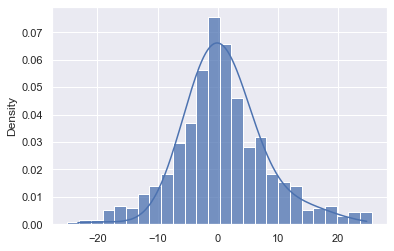

In [49]:
#GBM_crBTC1_d = np.array(Coefficient_matrix_GBM)[-1,1:-1]
Quantum_crBTC1_d = np.array(Coefficient_matrix)[-15,1:-1]
crBTC1_rg=25
crBTC1_t = np.sort([crBTC1[i] for i in range(len(crBTC1)) if -crBTC1_rg<=crBTC1[i]<=crBTC1_rg])
width = stats.freedman_bin_width((crBTC1), return_bins=False)
hist_plot = sns.histplot(data,stat="density", binwidth=width,binrange=(-crBTC1_rg,crBTC1_rg))
#plt.plot(crBTC1_t,GBM(GBM_crBTC1_d,crBTC1_t,1),color = 'r')
plt.plot(crBTC1_t,psisquare(Quantum_crBTC1_d,crBTC1_t),color = 'b')

## GBM 

In [50]:
#Inputs of the equation.
data = crBTC1
#Number of the weights we are looking to optimize.
num_weights = 2
#Defining the population size.
num_pop = 1000
pop_size = np.array([num_pop,num_weights])
#initializing populations
D_population = np.zeros((num_pop,num_weights))

D_population[:,0] = np.random.uniform(low=0.5, high=1.5, size = num_pop) #coefficienti μ
D_population[:,1] = np.random.uniform(low=3, high=4, size=num_pop) #coefficienti σ^2

In [51]:
GBMnum_generations = 40 #number of the generations decided
GBMnum_parents = 500 #number of the parents selected

In [52]:
#GBM PDF
#D is a vector with components mu and sigma^2
def GBM(D,x,t):
    mu = (D[0]-D[1]/2)*t
    sigma = D[1]*t
    return norm(mu, sigma).pdf(x)

In [53]:
def GBMFitness(x,D,t):
    M = len(x)
    return -(M)**(-1)*sum(np.log(GBM(D,x,t)))# - ApEn(ecdf(x)[1], m=2, r=3)

In [54]:
def GBMfitness_vector(x,D,t):
    T = np.array([GBMFitness(x,D[i,:],t) for i in range(D.shape[0])])
    for i in range(len(T)):
        if math.isnan(T[i])==True:
            T[i] = 9999999   
    return T

In [55]:
def GBMselection(fitness,D,number):
    #C = popolazione iniziale dei coefficienti
    #number = numero delle righe del nuovo vettore
    #fitness = fitness_vector(data,D)
    li = np.argsort(fitness)[:number]
    return np.array([D[b,:] for b in li])

In [56]:
def GBMcrossover(D):
    offspring = np.zeros(shape=D.shape)
    random_mu = random.randint(1,D.shape[0])
    random_sigma = random.randint(1,D.shape[0])
    for k in range(D.shape[0]):
        shift_mu = (k+random_mu)%D.shape[0]
        shift_sigma = (k+random_sigma)%D.shape[0]
        offspring[k,0] = D[shift_mu,0]
        offspring[k,1] = D[shift_sigma,1]
    return offspring

In [57]:
Coefficient_matrix_GBM = pd.DataFrame(columns=['Generation','GBMmu', 'GBMsigma','GBMFitness'])
for generation in range(GBMnum_generations):
    # Measuring the fitness of each chromosome in the population.
    GBMfitness = GBMfitness_vector(data,D_population,t=1)
    # Selecting the best parents in the population.
    GBMparents = GBMselection(GBMfitness,D_population,GBMnum_parents)
    # Generating next generation using crossover.
    GBMcross = GBMcrossover(GBMparents)
    # Adding some variations to the offsrping using mutation.
    GBMrow = GBMcross.shape[0]
    GBMcolumn = GBMcross.shape[1]
    GBMmutation_matrix = np.random.rand(GBMrow,GBMcolumn)*np.array([[random.randint(-1,1) for j in range(GBMcolumn)] for i in range(GBMrow)])
    GBMmutation_matrix+= np.ones((GBMrow,GBMcolumn))
    GBMmutant = GBMmutation_matrix*GBMcross
    # Creating the new population based on the parents and offspring.
    D_population[0:GBMnum_parents, :] = GBMparents
    D_population[GBMnum_parents:, :] = GBMmutant
    np.random.shuffle(D_population)
    # The best result in the current iteration.
    #print("Generation : ", generation + 1,"\nBest Parent:\n",try_population[np.where(fitness==np.min(fitness))],"\nMin Fitness Values :",np.min(fitness),"\n\n")
    GBMgen = np.insert(D_population[np.where(GBMfitness==np.min(GBMfitness))],  0,int(0 + 1))
    GBMgen = np.insert(GBMgen,len(GBMgen),np.min(GBMfitness)-entropy)
    Coefficient_matrix_GBM.loc[generation] = GBMgen
Coefficient_matrix_GBM

<ipython-input-53-7c35d306ec2e>:3: RuntimeWarning: divide by zero encountered in log
  return -(M)**(-1)*sum(np.log(GBM(D,x,t)))# - ApEn(ecdf(x)[1], m=2, r=3)


,Generation,GBMmu,GBMsigma,GBMFitness
0,1.0,0.013043,0.242942,5.646102
1,1.0,1.064859,3.952785,3.908636
2,1.0,0.488330,2.267532,3.791021
3,1.0,0.463174,6.270758,3.791021
4,1.0,1.646489,13.054611,3.763731
5,1.0,1.049371,9.873061,3.752511
6,1.0,0.464773,11.878977,3.752511
7,1.0,0.348514,10.626257,3.752511
8,1.0,1.420050,9.419356,3.749831
9,1.0,2.253146,15.552379,3.749100


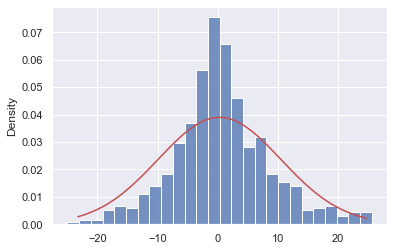

In [58]:
GBM_crBTC1_d = np.array(Coefficient_matrix_GBM)[-1,1:-1]
#Quantum_crBTC1_d = np.array(Coefficient_matrix)[-15,1:-1]
crBTC1_rg=25
crBTC1_t = np.sort([crBTC1[i] for i in range(len(crBTC1)) if -crBTC1_rg<=crBTC1[i]<=crBTC1_rg])
width = stats.freedman_bin_width((crBTC1), return_bins=False)
hist_plot = sns.histplot(data,stat="density", binwidth=width,binrange=(-crBTC1_rg,crBTC1_rg))
plt.plot(crBTC1_t,GBM(GBM_crBTC1_d,crBTC1_t,1),color = 'r')
#plt.plot(crBTC1_t,psisquare(Quantum_crBTC1_d,crBTC1_t),color = 'b')

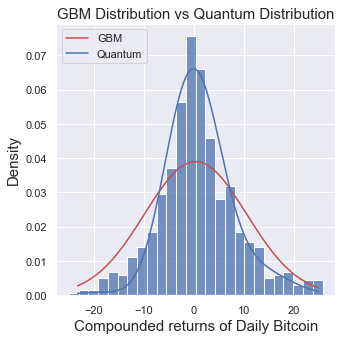

In [59]:
plt.figure(figsize=(5,5))
plt.title('GBM Distribution vs Quantum Distribution', fontsize='15')
plt.xlabel('Compounded returns of Daily Bitcoin', fontsize='15')
plt.ylabel('Density', fontsize='15')

GBM_crBTC1_d = np.array(Coefficient_matrix_GBM)[-1,1:-1]
Quantum_crBTC1_d = np.array(Coefficient_matrix)[-15,1:-1]
crBTC1_rg=25
crBTC1_t = np.sort([crBTC1[i] for i in range(len(crBTC1)) if -crBTC1_rg<=crBTC1[i]<=crBTC1_rg])
width = stats.freedman_bin_width((crBTC1), return_bins=False)
hist_plot = sns.histplot(data,stat="density", binwidth=width,binrange=(-crBTC1_rg,crBTC1_rg))
plt.plot(crBTC1_t,GBM(GBM_crBTC1_d,crBTC1_t,1),color = 'r',label='GBM')
plt.plot(crBTC1_t,psisquare(Quantum_crBTC1_d,crBTC1_t),color = 'b',label ='Quantum')

plt.legend(loc="upper left")

In [64]:
Quantum_crBTC1_d,GBM_crBTC1_d,np.array(Coefficient_matrix_GBM)[-1,-1],np.array(Coefficient_matrix)[-1,-1]

(array([ 4.81155078e-02,  5.52969396e-03, -1.82056753e-05,  1.03336203e-03,
         7.20499710e-04,  9.75350681e-03]),
 array([ 5.43912993, 10.23668579]),
 3.7489534603249375,
 3.6829283994286635)

In [65]:
#product between mass and angular frequency of the hoscillaotr
Quantum_crBTC1_d[-1]*hbar

1.0285773400231936e-36

In [66]:
#probabilities of the single eigenstate
n_Quantum_crBTC1_d=np.sum(Quantum_crBTC1_d[:-1]**2)
p_Quantum_crBTC1_d = (Quantum_crBTC1_d[:-1]**2)/n_Quantum_crBTC1_d
p_Quantum_crBTC1_d,np.sum(p_Quantum_crBTC1_d)

(array([9.86296913e-01, 1.30268592e-02, 1.41205337e-07, 4.54927853e-04,
        2.21159269e-04]),
 0.9999999999999999)

In [80]:
ApEn(crBTC5, m=2, r=3)

0.9112393628183599